<a href="https://colab.research.google.com/github/CardosoJr/bootcamp/blob/main/Labs/Lab_14_Feature_Selection_and_Dimensionality_Reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab - Feature Selection and Dimensionality Reduction 

### Feature Selection x Dimensionality Reduction 

Basicamente, podemos resumir em: 

* Feature Selection: Remover Features menos importantes
* Dimensionalty Reduction: Transformar o espaço de features em um espaço de menor dimensão 

In [ ]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
import warnings
warnings.filterwarnings('ignore')

# Importando libs de plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px



from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, accuracy_score, confusion_matrix, precision_recall_curve, auc, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

sns.set_style('darkgrid')
# sns.set_context('talk')
sns.set_palette('rainbow')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

## Feature Selection 

Existem diferentes abordagens para feature selection:

* Filter Methods:
  * Aplicamos alguma métrica para rankear features (correlação com target, mutual information, information value...) 
* Wrapper Methods:
  * Utilizamos algum modelo para plotar feature importance e remover as features com menor importância (Forward Feature Selection e Backward Feature Eliminiation)
* Embedded Methods:
  * Um modelo que já seleciona as melhores features ao longo do treinamento. Por exemplo, utilizando regularização L1.

In [ ]:
!pip install -q Boruta

     |████████████████████████████████| 56 kB 3.5 MB/s 


In [ ]:
!pip install -q category-encoders

     |████████████████████████████████| 69 kB 5.3 MB/s 


In [ ]:
df = pd.read_csv('tabular_playground_aug_22_train.csv')

In [ ]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [ ]:
df.drop(columns = ['id'], inplace = True)

In [ ]:
y = df.pop('failure')
X = df

cat_cols = ['product_code', 'attribute_0', 'attribute_1', 'attribute_2', 'attribute_3',]
one_hot_cols = [x for x in cat_cols if df[x].nunique() <= 3]
encoding_cols = list(set(cat_cols) - set(one_hot_cols))
numerical_cols = list(set(X.columns) - set(cat_cols))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [ ]:
enc1 = ce.OneHotEncoder(cols = one_hot_cols)
enc1.fit(X_train)
X_train = enc1.transform(X_train)
X_test = enc1.transform(X_test)

enc2 = ce.WOEEncoder(cols = encoding_cols)
enc2.fit(X_train, y_train)
X_train = enc2.transform(X_train)
X_test = enc2.transform(X_test)

imp = SimpleImputer()
imp.fit(X_train)
X_train = imp.transform(X_train)
X_test = imp.transform(X_test)

scaling = StandardScaler()
scaling.fit(X_train)
X_train = scaling.transform(X_train)
X_test = scaling.transform(X_test)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from boruta import BorutaPy

b = BorutaPy(estimator = AdaBoostClassifier(), max_iter = 50, n_estimators = 50, verbose = 1) 

b.fit(X_train, y_train)

Iteration: 1 / 50
Iteration: 2 / 50
Iteration: 3 / 50
Iteration: 4 / 50
Iteration: 5 / 50
Iteration: 6 / 50
Iteration: 7 / 50
Iteration: 8 / 50
Iteration: 9 / 50
Iteration: 10 / 50
Iteration: 11 / 50
Iteration: 12 / 50
Iteration: 13 / 50
Iteration: 14 / 50
Iteration: 15 / 50
Iteration: 16 / 50
Iteration: 17 / 50
Iteration: 18 / 50
Iteration: 19 / 50
Iteration: 20 / 50
Iteration: 21 / 50
Iteration: 22 / 50
Iteration: 23 / 50
Iteration: 24 / 50
Iteration: 25 / 50
Iteration: 26 / 50
Iteration: 27 / 50
Iteration: 28 / 50
Iteration: 29 / 50
Iteration: 30 / 50
Iteration: 31 / 50
Iteration: 32 / 50
Iteration: 33 / 50
Iteration: 34 / 50
Iteration: 35 / 50
Iteration: 36 / 50
Iteration: 37 / 50
Iteration: 38 / 50
Iteration: 39 / 50
Iteration: 40 / 50
Iteration: 41 / 50
Iteration: 42 / 50
Iteration: 43 / 50
Iteration: 44 / 50
Iteration: 45 / 50
Iteration: 46 / 50
Iteration: 47 / 50
Iteration: 48 / 50
Iteration: 49 / 50


BorutaPy finished running.

Iteration: 	50 / 50
Confirmed: 	1
Tentative: 	2


BorutaPy(estimator=AdaBoostClassifier(random_state=RandomState(MT19937) at 0x7F446795AAF0),
         max_iter=50, n_estimators=50,
         random_state=RandomState(MT19937) at 0x7F446795AAF0, verbose=1)

In [ ]:
b.ranking_

array([20,  1, 20, 13, 20, 20, 20, 14, 20,  8,  8,  8,  3,  3,  2,  8, 20,
       20, 20,  8, 11,  8, 20, 13,  3,  3,  2])

In [ ]:
features = []
acc = []
for f in b.ranking_:
  if len(features) > 100:
    break
  features.append(f)
  model = AdaBoostClassifier()
  model.fit(X_train[:, features], y_train)
  acc.append(roc_auc_score(y_test, model.predict_proba(X_test[:, features])[:,1])) 

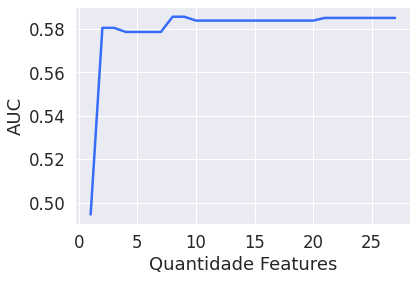

In [ ]:
sns.lineplot(np.arange(len(acc)) + 1, acc);
plt.xlabel("Quantidade Features")
plt.ylabel('AUC');

### MMR 

https://github.com/smazzanti/mrmr

In [ ]:
!pip install mrmr_selection

## Dimensionality Reduction

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.04, images=None, figsize=(13, 10)):
    X_normalized = MinMaxScaler().fit_transform(X)
    neighbors = np.array([[10., 10.]])
    plt.figure(figsize=figsize)
    cmap = plt.cm.jet
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1],
                    c=[cmap(float(digit) / 9)], alpha=0.5)
    plt.axis("off")
    ax = plt.gca() 
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(float(y[index]) / 9),
                         fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"),
                                          image_coord)
                ax.add_artist(imagebox)

### Introduzindo o dataset MNIST

In [ ]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

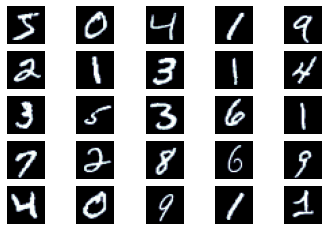

In [ ]:
fig, ax = plt.subplots(5,5)
ax = ax.flatten()
for i, im in enumerate(X_train[:25]): 
  ax[i].imshow(im, cmap='bone')
  ax[i].axis('off')

Cada imagem é composta de 28x28 pixels, ou seja, 784  features.

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
data = X_train.reshape(60000, 784)
scaler = StandardScaler()
data = scaler.fit_transform(data)

### Principal Component Analysis

-  Standardize the data.
-  Obtain the Eigenvectors and Eigenvalues from the covariance matrix or correlation matrix, or perform Singular Vector Decomposition.
-  Sort eigenvalues in descending order and choose the $k$ eigenvectors that correspond to the $k$ largest eigenvalues where $k$ is the number of dimensions of the new feature subspace ($k \le d$)/.
-  Construct the projection matrix $\mathbf{W}$ from the selected $k$ eigenvectors.
-  Transform the original dataset $\mathbf{X}$ via $\mathbf{W}$ to obtain a $k$-dimensional feature subspace $\mathbf{Y}$. \\


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
data_pca = pca.fit_transform(data)

pca.explained_variance_


array([40.4876351 , 29.24169736])

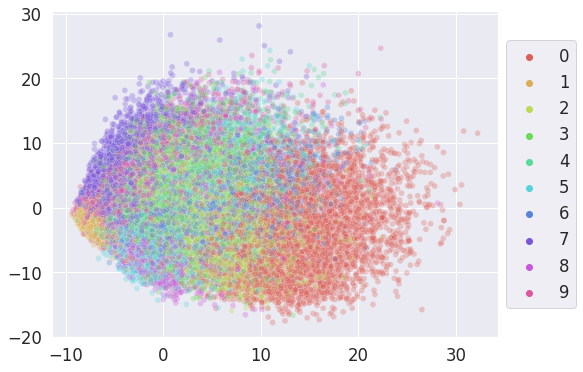

In [ ]:
fig, ax = plt.subplots(figsize = (8,6))
sns.scatterplot(data_pca[:,0], data_pca[:,1], hue = y_train, alpha = 0.3, legend = 'full', palette=sns.color_palette("hls", 10),);
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

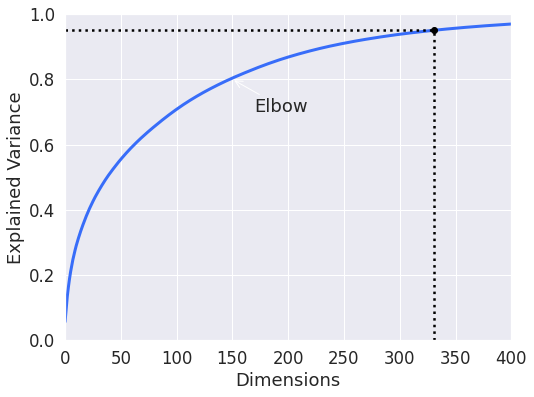

In [ ]:
pca = PCA(n_components = 0.99)
pca.fit(data)

fig, ax = plt.subplots(figsize = (8,6))

d = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1  # d equals 154
ax.plot(np.cumsum(pca.explained_variance_ratio_), linewidth=3)
plt.axis([-0.1, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
ax.plot([d, d], [0, 0.95], "k:")
ax.plot([0, d], [0.95, 0.95], "k:")
ax.plot(d, 0.95, "ko")
ax.annotate("Elbow", xy=(150, 0.80), xytext=(170, 0.7),
             arrowprops=dict(arrowstyle="->"));

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
data_pca = pca.fit_transform(data)
pca.explained_variance_


array([40.48763511, 29.24169739, 26.81180445])

In [ ]:
idx = np.random.choice(range(len(data)), size = 10000, replace = False)
data_pca = np.array(data_pca)

fig = px.scatter_3d(
    data_pca[idx,:], x=0, y=1, z=2,
    color = y_train[idx], labels={'color': 'classes'}, opacity=0.8)
fig.update_traces(marker_size=8)
fig.show()

### PCA (ou redução de dimensionalidade) pode ser usada para compressão

In [ ]:
data.shape

(60000, 784)

In [ ]:
pca = PCA(0.95)
X_reduced = pca.fit_transform(data, y_train)
X_recovered = pca.inverse_transform(X_reduced)

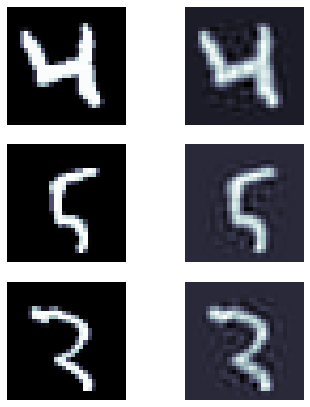

In [ ]:
fig, ax = plt.subplots(3, 2, figsize = (6,6))

img_index = [20, 100, 500]
im_original = scaler.inverse_transform(data)[img_index, : ].reshape(len(img_index),28,28)
im_recovered = scaler.inverse_transform(X_recovered)[img_index, : ].reshape(len(img_index),28,28)

for i in range(len(img_index)):
  ax[i,0].imshow(im_original[i],  cmap='bone')
  ax[i,0].axis('off')
  ax[i,1].imshow(im_recovered[i],  cmap='bone')
  ax[i,1].axis('off');

plt.tight_layout()

In [ ]:
pca = PCA(0.8)
X_reduced = pca.fit_transform(data, y_train)
X_recovered = pca.inverse_transform(X_reduced)

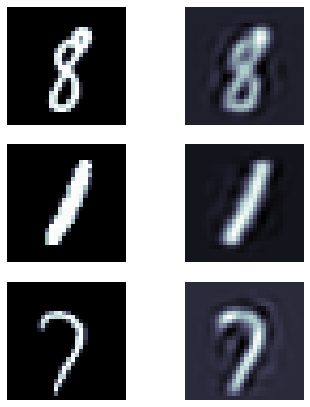

In [ ]:
fig, ax = plt.subplots(3, 2, figsize = (6,6))

img_index = [300, 357, 1022]
im_original = scaler.inverse_transform(data)[img_index, : ].reshape(len(img_index),28,28)
im_recovered = scaler.inverse_transform(X_recovered)[img_index, : ].reshape(len(img_index),28,28)

for i in range(len(img_index)):
  ax[i,0].imshow(im_original[i],  cmap='bone')
  ax[i,0].axis('off')
  ax[i,1].imshow(im_recovered[i],  cmap='bone')
  ax[i,1].axis('off');

plt.tight_layout()

Variações do PCA 
- Randomized PCA
- Kernel PCA

### T-SNE

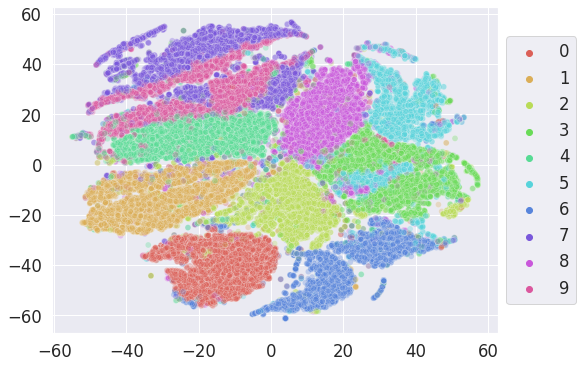

In [ ]:
from sklearn.manifold import TSNE
# designing model with default values perplexity = 30, n_iteration = 1000
model = TSNE(n_components=2, random_state=0)
data_tsne = model.fit_transform(data)

fig, ax = plt.subplots(figsize = (8,6))
sns.scatterplot(data_tsne[:,0], data_tsne[:,1], hue = y_train, alpha = 0.3, legend = 'full', palette=sns.color_palette("hls", 10),);
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [ ]:
model = TSNE(n_components=2, perplexity=40, n_iter=300)
data_tsne = model.fit_transform(data)

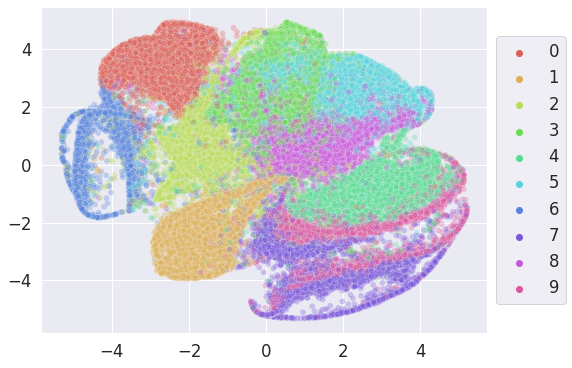

In [ ]:
fig, ax = plt.subplots(figsize = (8,6))
sns.scatterplot(data_tsne[:,0], data_tsne[:,1], hue = y_train, alpha = 0.3, legend = 'full', palette=sns.color_palette("hls", 10),);
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

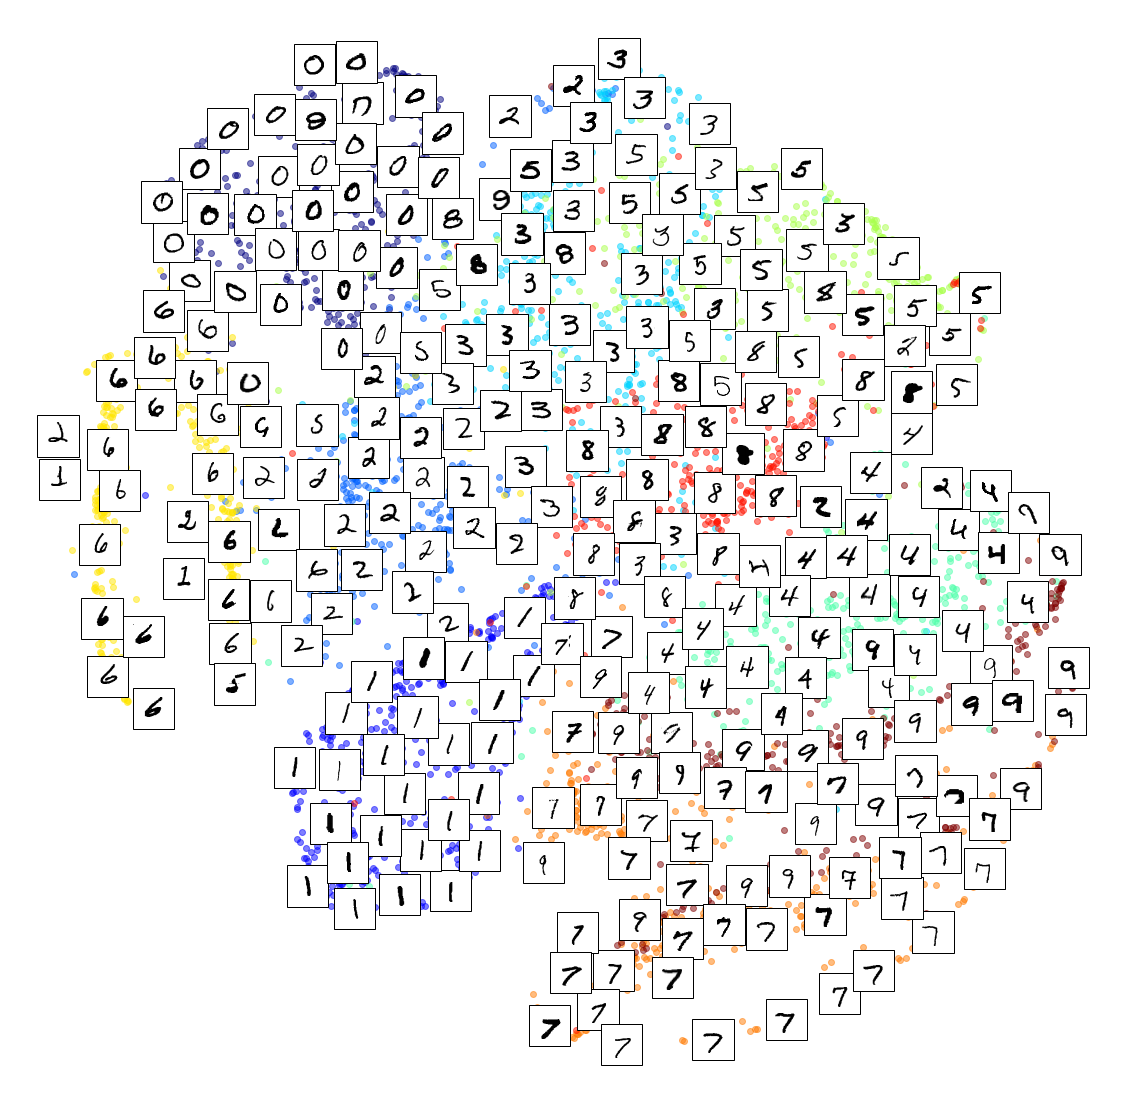

In [ ]:
idx = np.random.choice(range(len(data)), size = 5000, replace = False)
data_tsne_filtered = np.array(data_tsne)[idx,:]
y_train_filtered = y_train[idx]

plot_digits(data_tsne_filtered, y_train_filtered, min_distance=0.04, images=X_train[idx, :], figsize=(20, 20))

In [ ]:
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
data_tsne = tsne.fit_transform(data)

In [ ]:
idx = np.random.choice(range(len(data)), size = 10000, replace = False)
data_tsne = np.array(data_tsne)

fig = px.scatter_3d(
    data_tsne[idx,:], x=0, y=1, z=2,
    color = y_train[idx], labels={'color': 'classes'}, opacity=0.8)
fig.update_traces(marker_size=8)
fig.show()

Outros métodos no Sklearn:
* MDS
* Isomap
* LocallyLinearEmbedding

### UMAP

In [ ]:
!pip install -q umap-learn

     |████████████████████████████████| 88 kB 6.1 MB/s 
     |████████████████████████████████| 1.1 MB 47.4 MB/s 


In [ ]:
!pip install -q datashader

     |████████████████████████████████| 18.2 MB 1.8 MB/s 
     |████████████████████████████████| 76 kB 2.0 MB/s 


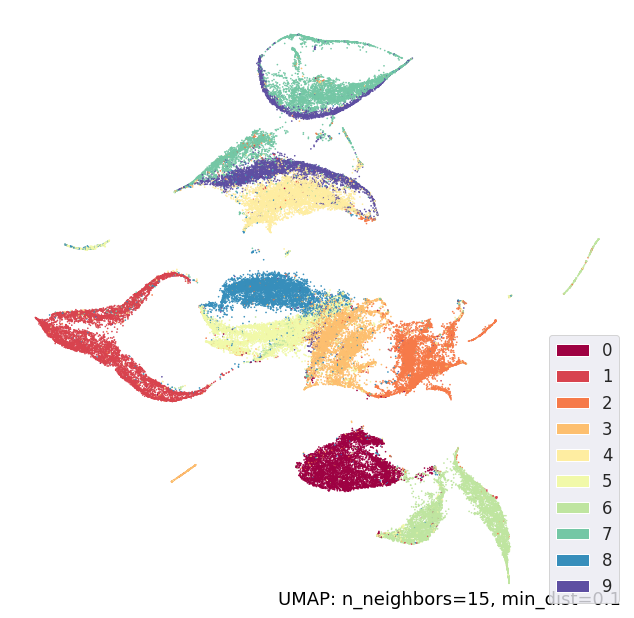

In [ ]:
import umap
import umap.plot

mapper = umap.UMAP().fit(data)
umap.plot.points(mapper, labels = y_train)

### Abordagens mais avançadas: 
* Deep Learning: modelos generativos, autoencoders, RBMs...
